In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
style.use('ggplot')
import seaborn as sns
import tqdm
import random

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold

import warnings
warnings.filterwarnings("ignore")

data_dir = '/mnt/elice/dataset'

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# 재현성 확보를 위해 시드값을 고정합니다.
seed = 42
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# About Dataset

- Info :
    - X 변수들은 SSD신뢰성에 영향을 줄 수 있는 SMART Attribute (비식별화된 상태)
    - Y는 특정 기준에 따라 분류된 Pass(0)/Fail(1)
    - 한 Serial Number에 대해 여러 개의 Row가 존재하지만 Y 값은 Serial Number 별로 동일한 값을 가짐
    - X 변수는 18개

|Index|Features|Format|Description|
|----|----|----|:----|
|1|Serial Number|15|Serial Number|
|2|TIMESTAMP|2020.2.9  4:59:00 AM|Date-time reference|
|3|X1|EI83N072710203N8D|Equipment name|
|4|X2~18|27|Features|

In [3]:
# train_df: serial number, timestamp, X1, X2~18, Y
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"), index_col='Serial Number')
# test_x: serial number, timestamp, X1, X2~18
test_x = pd.read_csv(os.path.join(data_dir, "test_x.csv"), index_col='Serial Number')

''' timestamp 열 형식 바꾸기 '''
train_df['TIMESTAMP'] = pd.to_datetime(train_df['TIMESTAMP'])
train_df['TIMESTAMP'] = train_df['TIMESTAMP'].map(lambda t: t.strftime('%Y-%m-%d %H:%M'))
test_x['TIMESTAMP'] = pd.to_datetime(test_x['TIMESTAMP'])
test_x['TIMESTAMP'] = test_x['TIMESTAMP'].map(lambda t: t.strftime('%Y-%m-%d %H:%M'))

''' 컬럼 키 추출 '''
serial_key = train_df.index.name
date_time_key = list(train_df.columns)[0]
feature_keys = list(train_df.columns)[2:-1]
target_key = list(train_df.columns)[-1]

# train_x: serial number, timestamp, X1, X2~18
train_x = train_df.drop(columns='Y')
# train_y: serial_number, Y
train_y = pd.read_csv(os.path.join(data_dir, "train_y.csv"), index_col='Serial Number')

In [4]:
print(serial_key)
print(date_time_key)
print(feature_keys)
print(target_key)

Serial Number
TIMESTAMP
['X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
Y


In [5]:
print('----------------DF Shape-----------------\n')
print('shape of train_df:', train_df.shape)
print('shape of train_x:', train_x.shape)
print('shape of train_y:', train_y.shape)
print('shape of test_x:', test_x.shape)

print('\n---------------DF Summary----------------\n')
print(train_df.info())
print(train_df.describe())

print('\n---------------Unique Values-------------\n')
unique_list = {}
for col in ['TIMESTAMP', 'X1']:
        unique_list[col] = train_df[col].unique()
print(unique_list)

print('\n---------------Missing Values-------------\n')
print(train_df.isnull().sum())

----------------DF Shape-----------------

shape of train_df: (555456, 20)
shape of train_x: (555456, 19)
shape of train_y: (8272, 1)
shape of test_x: (138880, 19)

---------------DF Summary----------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555456 entries, 19 to 113926
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   TIMESTAMP  555456 non-null  object 
 1   X1         555456 non-null  object 
 2   X2         555456 non-null  int64  
 3   X3         555456 non-null  int64  
 4   X4         555456 non-null  int64  
 5   X5         555456 non-null  int64  
 6   X6         555456 non-null  int64  
 7   X7         555456 non-null  int64  
 8   X8         555456 non-null  int64  
 9   X9         555456 non-null  int64  
 10  X10        555456 non-null  int64  
 11  X11        555456 non-null  float64
 12  X12        555456 non-null  float64
 13  X13        555456 non-null  float64
 14  X14        555456 n

In [6]:
train_x.head()

,TIMESTAMP,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
Serial Number,,,,,,,,,,,,,,,,,,,
19,2020-02-09 16:24,EI83N072710203N8H,22,18,22,16,32,99,91219,43095,2132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,2020-02-10 16:39,EI83N072710203N8H,22,18,22,16,32,99,91413,43214,2133,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,2020-02-11 16:54,EI83N072710203N8H,22,18,22,16,32,99,91606,43332,2135,49.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
19,2020-02-12 17:09,EI83N072710203N8H,22,18,22,16,32,99,91799,43449,2136,73.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
19,2020-02-13 17:24,EI83N072710203N8H,22,18,23,16,32,99,91991,43566,2137,97.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0


In [7]:
test_x.head()

,TIMESTAMP,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
Serial Number,,,,,,,,,,,,,,,,,,,
100122I,2020-02-09 13:08,EJ86N538510606DC8,76,74,22,12,30,99,62160,27565,1980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100122I,2020-02-10 13:23,EJ86N538510606DC8,76,74,22,12,30,99,62332,27652,1983,24.0,20.0,0.0,0.0,20.0,0.0,0.0,0.0
100122I,2020-02-11 13:38,EJ86N538510606DC8,76,74,22,12,30,99,62501,27737,1985,48.0,30.0,0.0,0.0,30.0,0.0,0.0,0.0
100122I,2020-02-12 13:53,EJ86N538510606DC8,76,74,22,12,30,99,62670,27819,1988,73.0,43.0,0.0,0.0,43.0,0.0,0.0,0.0
100122I,2020-02-13 14:08,EJ86N538510606DC8,76,74,22,12,30,99,62843,27906,1989,97.0,61.0,0.0,0.0,61.0,0.0,0.0,0.0


In [8]:
# Serial Number의 unique 값
print("Train Data의 Serial Number의 unique 값 :", len(train_x.index.unique()))
print("Test Data의 Serial Number의 unique 값 :", len(test_x.index.unique()))

Train Data의 Serial Number의 unique 값 : 8272
Test Data의 Serial Number의 unique 값 : 2069


# Distribution of Y

In [9]:
train_y.head()

,Y
Serial Number,
19,1
42,1
48,1
51,1
67,1


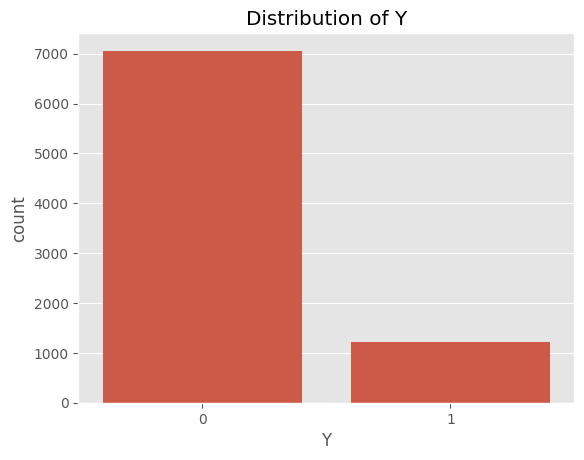

In [10]:
sns.countplot(x='Y', data=train_y)
plt.title('Distribution of Y')
plt.show()

In [11]:
train_y['Y'].value_counts()

0    7060
1    1212
Name: Y, dtype: int64

In [12]:
train_y['Y'].value_counts(normalize=True)

0    0.853482
1    0.146518
Name: Y, dtype: float64

In [13]:
train_df['Y'].value_counts(normalize=True)

0    0.855994
1    0.144006
Name: Y, dtype: float64

# 데이터 전처리

## 장비 이름을 나타내는 X1 변수를 제거

In [14]:
train_x.drop(columns='X1', inplace=True)
test_x.drop(columns='X1', inplace=True)

## `StandardScaler` 를 활용해 표준화 

In [15]:
scaler = StandardScaler()

train_x[feature_keys] = scaler.fit_transform(train_x[feature_keys])
test_x[feature_keys] = scaler.transform(test_x[feature_keys])

## Serial Number를 기준으로 분리

In [16]:
# 데이터를 index가 같은 컬럼 별로 분리해서 리스트에 저장
# group: (그룹 이름, 그룹 데이터프레임) => group[1]: 그룹 데이터프레임
train_x_by_serial = [group[1] for group in train_x.groupby(train_x.index)]
test_x_by_serial = [group[1] for group in test_x.groupby(test_x.index)]

# TIMESTAMP 값을 기준으로 정렬
train_x_by_serial = [group.sort_values('TIMESTAMP') for group in train_x_by_serial]
test_x_by_serial = [group.sort_values('TIMESTAMP') for group in test_x_by_serial]

In [17]:
train_x_by_serial[2]

,TIMESTAMP,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
Serial Number,,,,,,,,,,,,,,,,,,
48,2020-02-09 08:01,0.237359,0.176644,1.060111,1.067976,1.258588,-0.079582,0.845695,0.629975,0.059574,-1.734490,-0.465737,-0.012637,-0.035175,-0.464819,-0.010677,-0.011952,-0.013366
48,2020-02-10 08:16,0.237359,0.176644,1.060111,1.067976,1.258588,-0.079582,0.849884,0.633251,0.059664,-1.684896,-0.410967,-0.012621,-0.035175,-0.409868,-0.010677,-0.011952,-0.012643
48,2020-02-11 08:31,0.237359,0.176644,1.060111,1.067976,1.258588,-0.079582,0.854143,0.636589,0.059844,-1.635302,-0.315119,-0.012613,-0.035175,-0.313703,-0.010677,-0.011952,-0.012282
48,2020-02-12 08:46,0.237359,0.176644,1.060111,1.067976,1.258588,-0.079582,0.858803,0.640521,0.060115,-1.583642,-0.219271,-0.012589,-0.035175,-0.217539,-0.010677,-0.011952,-0.011199
48,2020-02-13 09:01,0.237359,0.176644,1.060111,1.067976,1.258588,-0.079582,0.863227,0.644140,0.060295,-1.534048,-0.127987,-0.012589,-0.035175,-0.125954,-0.010677,-0.011952,-0.011199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,2020-04-14 00:01,0.237359,0.176644,1.407310,1.067976,1.258588,-0.079582,1.133848,0.867393,0.078570,1.480844,4.029984,-0.012373,-0.035175,4.045745,-0.010677,-0.011952,-0.001446
48,2020-04-15 00:16,0.237359,0.176644,1.407310,1.067976,1.258588,-0.079582,1.138296,0.870981,0.078840,1.530438,4.198859,-0.012345,-0.035175,4.215177,-0.010677,-0.011952,-0.000362
48,2020-04-16 00:31,0.237359,0.176644,1.407310,1.067976,1.258588,-0.079582,1.142649,0.874445,0.079110,1.580032,4.317527,-0.012345,-0.035175,4.334238,-0.010677,-0.011952,-0.000362


In [18]:
train_x_by_serial[2].index.unique()

Int64Index([48], dtype='int64', name='Serial Number')

In [19]:
train_x_by_serial[2].index.unique().item()

48

In [20]:
train_y.loc[54509]

Y    0
Name: 54509, dtype: int64

## train, valid 분할

학습용 데이터셋과 검증용 데이터셋을 생성합니다. 데이터의 Serial Number를 기준으로 8:2 비율로 분할하고, 동시에 학습용 데이터셋과 검증용 데이터셋의 Y 비율이 Serial Number 수 기준으로 비슷하도록 분할합니다.

In [21]:
def train_test_split(Xs, ys, test_ratio=0.2):
    ''' 각 (x, y) 쌍을 label 별로 딕셔너리에 저장 '''
    data_per_label = {}

    for x, y in zip(Xs, ys):
        label = y
        if label not in data_per_label:
            data_per_label[label] = []
        # key: label, value: 해당 label에 해당하는 (x, y) 쌍의 리스트
        data_per_label[label].append((x, y))

    train = []
    test = []

    for label in data_per_label:
        # label에 해당하는 데이터 가져온다
        data = data_per_label[label]
        # 테스트 데이터의 개수
        n_test = int(len(data) * test_ratio)
        test += data[:n_test]
        train += data[n_test:]

    X_train, y_train = zip(*train)
    X_test, y_test = zip(*test)

    return X_train, X_test, y_train, y_test

In [22]:
X_train, X_val, y_train, y_val = train_test_split(train_x_by_serial, train_y['Y'], test_ratio=0.2)

# X data에서 Timestamp를 제거합니다.
X_train = [x.drop(columns='TIMESTAMP') for x in X_train]
X_val = [x.drop(columns='TIMESTAMP') for x in X_val]
X_test = [x.drop(columns='TIMESTAMP') for x in test_x_by_serial]

print("Train Data의 개수 :", len(X_train))
print("Validation Data의 개수 :", len(X_val))
print("Test Data의 개수 :", len(X_test))

Train Data의 개수 : 6618
Validation Data의 개수 : 1654
Test Data의 개수 : 2069


## 머신러닝 모델에 적용하기 위해 학습, 검증, 테스트용 데이터를 각각 하나의 numpy array로 합칩니다.

In [23]:
def align_data(data, series_length):
    # X2~18열에 해당하는 시계열 데이터 값만 추출
    data_features = [x[feature_keys] for x in data]
    len_data = len(data_features)
    length_aligned_X = []
    for x in data_features:
        # 시계열 데이터 길이가 series_length 이상이면 > 뒷부분 잘라냄
        if len(x) >= series_length:
            length_aligned_X.append(x[:series_length])
        # 시계열 데이터 길이가 series_length보다 작으면 > 마지막 행을 반복하여 길이를 맞춤
        else:
            length_aligned_X.append(x.append([x.iloc[-1]] * (series_length - len(x))))
    return np.array(length_aligned_X).reshape(len_data, -1)

In [24]:
series_length = 50

X_train = align_data(X_train, series_length)
X_val = align_data(X_val, series_length)
X_test = align_data(X_test, series_length)

In [25]:
17 * 50

850

In [26]:
len(X_train[0])

850

y data도 numpy array로 변환합니다.

In [27]:
y_train = np.array(y_train)
y_val = np.array(y_val)

In [28]:
y_train

array([1, 1, 1, ..., 0, 0, 0])

# 모델 학습

## baseline

In [29]:
'''
# Scikit-learn을 활용해서 시계열 데이터 분류 모델을 학습합니다.
# RandomForestClassifier 객체 생성
clf = DecisionTreeClassifier(random_state=42)

# 학습 데이터에 대해 학습
clf.fit(X_train, y_train)

# 학습 데이터에 대해 예측
y_train_pred = clf.predict(X_train)
# 학습 데이터에 대한 F1 score 계산
f1_train = f1_score(y_train, y_train_pred, average='macro')

# 검증 데이터에 대해 예측
y_val_pred = clf.predict(X_val)
# 검증 데이터에 대한 F1 Score 계산
f1_val = f1_score(y_val, y_val_pred, average='macro')

print(f'학습 데이터에 대한 F1 Score: {f1_train:.4f}')
print(f'검증 데이터에 대한 F1 Score: {f1_val:.4f}')

SyntaxError: incomplete input (403235461.py, line 1)

## Fitting XGBoost with GridSearchCV

In [30]:
def xgb_gridsearchcv(model, param_grid, X_train, y_train):

    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    # define grid search
    grid = GridSearchCV(estimator = model, 
                        param_grid = param_grid, 
                        n_jobs = -1, 
                        cv = cv, 
                        scoring = 'f1_macro')
    grid.fit(X_train, y_train)
    results = grid.cv_results_
    best = grid.best_estimator_
    params = grid.best_params_
    scores = grid.best_score_
    print('Best Parameters : ', params)
    print('Best F1 score : ', scores)
    
    # 각 파라미터 조합에 대한 결과를 데이터프레임으로 변환
    results_df = pd.DataFrame(results)
    display(results_df)
    
    return params, scores, results_df

### 1. scale_pos_weight

In [50]:
fail_ratio = (y_train == 1).sum() / len(y_train)
scale_pos_weight = 1 / fail_ratio
print(scale_pos_weight)

model = XGBClassifier(scale_pos_weight = scale_pos_weight, 
                      random_state = 42)
model.fit(X_train, y_train)

# 검증 데이터에 대한 예측
y_val_pred = model.predict(X_val)
# 검증 데이터에 대한 F1 점수 계산
f1_val = f1_score(y_val, y_val_pred, average='macro')
print('Validation F1 score = %.3f' % f1_val)

6.822680412371134
Validation F1 score = 0.833


In [30]:
param_grid = {
    'scale_pos_weight' : [1, 2, 3, 4, 5, 6],
}

# define model
model = XGBClassifier(random_state = 42)

In [31]:
xgb_gridsearchcv(model, param_grid, X_train, y_train)

Best Parameters :  {'scale_pos_weight': 1}
Best F1 score :  0.9583066009101773


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,6.442746,0.117648,0.008846,0.000497,1,{'scale_pos_weight': 1},0.966054,0.956985,0.966640,0.966054,...,0.937449,0.949504,0.966054,0.958430,0.960574,0.956974,0.943690,0.958307,0.010901,1
1,6.693264,0.059900,0.008938,0.000588,2,{'scale_pos_weight': 2},0.959524,0.950840,0.954895,0.975420,...,0.925607,0.956985,0.953710,0.958430,0.969802,0.963440,0.941862,0.956291,0.010909,3
2,6.862927,0.079549,0.008959,0.000840,3,{'scale_pos_weight': 3},0.966640,0.948443,0.961238,0.978398,...,0.931806,0.953710,0.951266,0.959108,0.958080,0.966915,0.945160,0.958004,0.010178,2
3,6.985097,0.092770,0.008888,0.000358,4,{'scale_pos_weight': 4},0.959882,0.953710,0.955274,0.972226,...,0.936312,0.956604,0.951266,0.959108,0.970057,0.955262,0.946538,0.955663,0.009340,5
4,7.068246,0.086863,0.009009,0.000404,5,{'scale_pos_weight': 5},0.957358,0.948443,0.958430,0.972226,...,0.942378,0.954113,0.957358,0.956008,0.961559,0.955633,0.951671,0.954501,0.008661,6
5,7.119735,0.123249,0.008572,0.001195,6,{'scale_pos_weight': 6},0.960232,0.939604,0.967201,0.978398,...,0.945644,0.947537,0.948443,0.956364,0.964368,0.958069,0.936837,0.956244,0.010582,4


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 {'scale_pos_weight': 1},
 0.9583066009101773,
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
 0       6.442746      0.117648         0.008846        0.000497   
 1       6.693264      0.059900         0.008938 

In [33]:
model = XGBClassifier(scale_pos_weight = 1, 
                      random_state = 42)
model.fit(X_train, y_train)

# 검증 데이터에 대한 예측
y_val_pred = model.predict(X_val)
# 검증 데이터에 대한 F1 점수 계산
f1_val = f1_score(y_val, y_val_pred, average='macro')
print('Validation F1 score = %.3f' % f1_val)

Validation F1 score = 0.847


## 2. min_child_weight, max_depth, colsample_bytree, subsample

- min_child_weight : the minimum sum of instance weight needed in a child node

- max_depth : the maximum depth of a tree

- colsample_bytree : the proportion of randomly selected features to be considered in building each decision tree

- subsample : the fraction of the dataset used for training each individual tree

In [31]:
param_grid = {
    'min_child_weight' : [1, 3, 5],
    'max_depth' : [3, 4, 5, 6],
    'colsample_bytree' : [0.5, 0.8, 1],
    }
# define model
model = XGBClassifier(scale_pos_weight = 1,
                      random_state = 42)

In [32]:
xgb_gridsearchcv(model, param_grid, X_train, y_train)

Best Parameters :  {'colsample_bytree': 1, 'max_depth': 3, 'min_child_weight': 3}
Best F1 score :  0.9596968454255753


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,2.943575,0.046353,0.007233,0.000727,0.5,3,1,"{'colsample_bytree': 0.5, 'max_depth': 3, 'min...",0.966350,0.956985,...,0.940308,0.953710,0.959158,0.955645,0.966350,0.969534,0.944191,0.957065,0.008568,32
1,2.826288,0.043312,0.007190,0.000759,0.5,3,3,"{'colsample_bytree': 0.5, 'max_depth': 3, 'min...",0.965441,0.947537,...,0.942669,0.953297,0.950840,0.958430,0.969541,0.966915,0.944681,0.959138,0.009235,6
2,2.750087,0.080151,0.007065,0.000596,0.5,3,5,"{'colsample_bytree': 0.5, 'max_depth': 3, 'min...",0.975202,0.953710,...,0.943704,0.955816,0.947070,0.958772,0.963762,0.963753,0.950828,0.956892,0.008262,33
3,3.600597,0.220311,0.007866,0.001186,0.5,4,1,"{'colsample_bytree': 0.5, 'max_depth': 4, 'min...",0.971978,0.959882,...,0.940843,0.966054,0.969003,0.952883,0.963762,0.963440,0.947524,0.958843,0.009276,9
4,3.355213,0.037350,0.007818,0.000873,0.5,4,3,"{'colsample_bytree': 0.5, 'max_depth': 4, 'min...",0.963130,0.962803,...,0.947070,0.962803,0.952443,0.955274,0.972705,0.966631,0.940828,0.958706,0.010390,11
5,3.234619,0.039476,0.007779,0.000267,0.5,4,5,"{'colsample_bytree': 0.5, 'max_depth': 4, 'min...",0.971978,0.962803,...,0.940843,0.962470,0.949504,0.958430,0.975842,0.957712,0.945160,0.957708,0.010056,25
6,4.362332,0.059121,0.008315,0.000618,0.5,5,1,"{'colsample_bytree': 0.5, 'max_depth': 5, 'min...",0.963130,0.962470,...,0.939761,0.946591,0.962128,0.961559,0.966640,0.966341,0.944681,0.957813,0.008263,23
7,3.880772,0.073793,0.007925,0.000468,0.5,5,3,"{'colsample_bytree': 0.5, 'max_depth': 5, 'min...",0.969275,0.962803,...,0.953710,0.953710,0.956214,0.958772,0.969541,0.954497,0.952863,0.959176,0.007710,5
8,3.731140,0.090591,0.008228,0.000686,0.5,5,5,"{'colsample_bytree': 0.5, 'max_depth': 5, 'min...",0.959882,0.950405,...,0.938006,0.950405,0.959882,0.958430,0.969802,0.969534,0.940828,0.956550,0.009582,35
9,5.002520,0.098173,0.008458,0.000414,0.5,6,1,"{'colsample_bytree': 0.5, 'max_depth': 6, 'min...",0.971978,0.953710,...,0.939761,0.943704,0.953297,0.955645,0.963762,0.972461,0.943690,0.957563,0.009836,27


({'colsample_bytree': 1, 'max_depth': 3, 'min_child_weight': 3},
 0.9596968454255753,
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
 0        2.943575      0.046353         0.007233        0.000727   
 1        2.826288      0.043312         0.007190        0.000759   
 2        2.750087      0.080151         0.007065        0.000596   
 3        3.600597      0.220311         0.007866        0.001186   
 4        3.355213      0.037350         0.007818        0.000873   
 5        3.234619      0.039476         0.007779        0.000267   
 6        4.362332      0.059121         0.008315        0.000618   
 7        3.880772      0.073793         0.007925        0.000468   
 8        3.731140      0.090591         0.008228        0.000686   
 9        5.002520      0.098173         0.008458        0.000414   
 10       4.312735      0.059002         0.008179        0.000735   
 11       4.043182      0.048241         0.008233        0.001414   
 12       3.17229

In [33]:
model = XGBClassifier(scale_pos_weight = 1,
                      colsample_bytree = 1, 
                      max_depth = 3, 
                      min_child_weight = 3,   
                      random_state = 42)
model.fit(X_train, y_train)

# 검증 데이터에 대한 예측
y_val_pred = model.predict(X_val)
# 검증 데이터에 대한 F1 점수 계산
f1_val = f1_score(y_val, y_val_pred, average='macro')
print('Validation F1 score = %.3f' % f1_val)

Validation F1 score = 0.849


# 모델 평가 및 결과 저장


In [34]:
submission = pd.read_csv(os.path.join(data_dir, "test_y.csv"), index_col='Serial Number')

# 테스트 데이터에 대해 예측하고, 결과를 저장합니다.
y_test_pred = model.predict(X_test)
submission["Y"] = y_test_pred
submission.to_csv("submission.csv", index_label='Serial Number')

### 결과 검증

`submission.csv` 파일을 다시 불러와 올바르게 값을 채웠는지 다시 한번 확인합니다.

In [35]:
submission = pd.read_csv("submission.csv", index_col='Serial Number')
submission

,Y
Serial Number,
100122I,1
100368G,0
101403L,0
101426G,0
101505B,0
...,...
997719U,0
998737L,0
999308S,0


In [36]:
# 예측 결과 중 1의 비율을 계산하고, 학습용 데이터의 비율과 비교합니다.
print(submission["Y"].mean())
print(train_y.mean())

0.20927984533591107
Y    0.146518
dtype: float64


### 제출

우측 상단의 제출 버튼을 눌러, `competition.ipynb` 파일과 `submission.csv` 파일을 제출합니다.